In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scoutsy.db_ops import create_connection
import numpy as np
from dotenv import load_dotenv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
load_dotenv(".env", override=True);

In [3]:
db = 'data/wsdm_data.db'
conn = create_connection(db)
cur = conn.cursor()

## Loading the dataset

The following code will load the dataset and display the first few rows of the dataset. This is the data that used in the paper.

In [4]:
results_query = """
SELECT
    topic_id,
    model_name,
    winner_resource_id,
    llm_response,
    input_token_usage,
    output_token_usage,
    error,
    status,
    pairs_evaluation_set_id,
    text,
    tag,
    description,
    "order",
    token_count_estimate,
    base_accepted_resource_id,
    accepted_resource_id,
    rejected_resource_id,
    Topics.title,
    Courses.title as course_title
FROM PairsPromptResult
JOIN PairsPrompt PP ON PairsPromptResult.pairs_prompt_id = PP.id
JOIN PairsEvaluationSet PES ON PP.pairs_evaluation_set_id = PES.id
JOIN Topics ON PES.topic_id = Topics.id
JOIN Courses ON Topics.course_id = Courses.id
WHERE "order" = "accepted_rejected" and tag="v1_no_force_prompt" 
"""

results_df = pd.read_sql_query(results_query, conn)
results_df.head(2)


,topic_id,model_name,winner_resource_id,llm_response,input_token_usage,output_token_usage,error,status,pairs_evaluation_set_id,text,tag,description,order,token_count_estimate,base_accepted_resource_id,accepted_resource_id,rejected_resource_id,title,course_title
0,50,gpt-4o-mini,937,candidate_1,4080.0,3.0,None,valid,18743,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,4021,936,937,935,Acute vs Chronic Stress,stress management and mental health
1,50,gpt-4o-mini,937,candidate_1,2448.0,3.0,None,valid,18744,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2389,936,937,940,Acute vs Chronic Stress,stress management and mental health


In [5]:
results_df["model_name"].unique() # model considered in this paper

array(['gpt-4o-mini', 'gpt-4o'], dtype=object)

In [6]:
# Load the previous work results and extract the top 2 to compare
old_perf = pd.read_json(
    "data/old_res.json",
    orient="columns",
)
old_perf = old_perf[["voyage-large-2-instruct","Baseline"]]
old_perf = old_perf.reset_index().rename(columns={'index':"title"})

## Compute the Accuracy

In [7]:
results_df["accuracy"] = results_df.apply(lambda x : 1 if x["winner_resource_id"] == x["accepted_resource_id"] else 0, axis=1)
results_df.head(3)

,topic_id,model_name,winner_resource_id,llm_response,input_token_usage,output_token_usage,error,status,pairs_evaluation_set_id,text,tag,description,order,token_count_estimate,base_accepted_resource_id,accepted_resource_id,rejected_resource_id,title,course_title,accuracy
0,50,gpt-4o-mini,937,candidate_1,4080.0,3.0,None,valid,18743,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,4021,936,937,935,Acute vs Chronic Stress,stress management and mental health,1
1,50,gpt-4o-mini,937,candidate_1,2448.0,3.0,None,valid,18744,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2389,936,937,940,Acute vs Chronic Stress,stress management and mental health,1
2,50,gpt-4o-mini,937,candidate_1,1897.0,3.0,None,valid,18745,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,1838,936,937,943,Acute vs Chronic Stress,stress management and mental health,1


In [8]:
perf = results_df.groupby(["course_title","title","model_name","base_accepted_resource_id","tag"]).agg({"accuracy":"mean"}).reset_index().groupby(["course_title","title","model_name","tag"]).agg({"accuracy":"mean"}).reset_index()
# accuracy of the new model for the first 5 topics (Paper results)
perf.pivot_table(index="title",columns=["model_name"],values=["accuracy"]).head(5)  

accuracy            
model_name                    gpt-4o gpt-4o-mini
title                                           
Acute vs Chronic Stress     0.838384    0.854545
Body's reaction to Stress   0.715873    0.604762
Chain of Thought Prompting  0.874747    0.826263
Comments in Python          0.874150    0.908163
Conditions in Python        0.799320    0.625850

In [9]:
f =results_df.groupby(["title","model_name",]).agg({"accuracy":"mean"}).reset_index().pivot_table(index="title",columns="model_name",values="accuracy")

In [10]:
p = f.join(old_perf.set_index("title")).reset_index()

In [11]:
p = p.melt(id_vars="title",value_vars=["voyage-large-2-instruct","Baseline","gpt-4o","gpt-4o-mini"])

In [12]:
new = perf.pivot(index=["course_title","title"],columns="model_name",values="accuracy")
plot = new.join(old_perf.set_index("title"))


In [13]:
rename_dict= {"Agile Scrum":"Agile Project Management","Learn LaTex":"Using LaTex","stress\nmanagement\nand mental\nhealth":"Mental health",}

In [14]:
h = plot.reset_index().melt(id_vars="course_title",value_vars=["Baseline","voyage-large-2-instruct","gpt-4o","gpt-4o-mini"],value_name="accuracy",var_name = "model_name")
h.rename(columns={"model_name":"Model"}, inplace=True)

rename_dict= {"Agile Scrum":"Agile Project Management","Learn LaTex":"Using LaTex","stress management and mental health":"Mental health",}
h["course_title"] = h["course_title"].apply(lambda x: rename_dict.get(x,x))

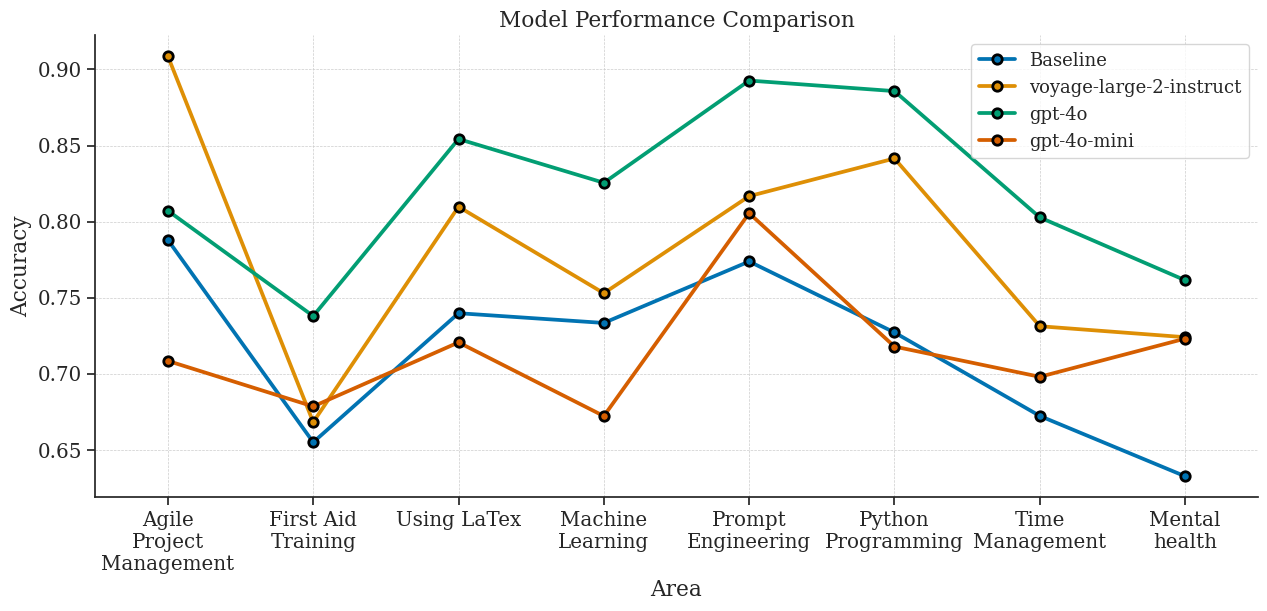

In [15]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    # "grid.color": "1",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    # "pgf.texsystem": "pdflatex",
    "font.family": "serif",
}

sns.set_theme(style="ticks", rc=custom_params, palette="colorblind", font_scale=1.3,)
h["course_title"] = ['\n'.join(wrap(x, 12)) for x in  h['course_title']]
fig,ax = plt.subplots(figsize=(15,6))
ax = sns.pointplot(data=h, x="course_title", y="accuracy", hue="Model",errorbar=None,markeredgecolor="black")
ax.set_xlabel("Area")
ax.set_ylabel("Accuracy")
plt.grid(True);
plt.title("Model Performance Comparison");
plt.legend(fontsize='small')
plt.savefig("wsdm_performance_2.pdf", bbox_inches='tight', dpi=300)

